### **Задание 1**

1. Автокорреляция порядка n - это корреляция между текущими значениями наблюдений временного ряда и значениями этого временного ряда n шагов (лагов) назад.

   Частичная автокорреляция порядка n - это корреляция между текущими значениями наблюдений временного ряда и значениями этого временного ряда n шагов (лагов) назад при исключении влиянияния промежуточных наблюдений (1, 2, ..., n-1 шага назад).

2. Стационарный временной ряд - это такой временной ряд, вероятностные характеристики которого (среднее значение, дисперсия, автокорреляция) не меняются со временем. Временной ряд с трендом не может быть стационарным (меняется, как минимум, среднее значение ряда), а ряд с циклом может быть стационарным.

3. Критерий Дики-Фуллера - это критерий для проверки наличия у временного ряда единичного корня, или стационарности после исключения тренда. Временной ряд имеет единичный корень, если первые разности временного ряда (т.е. ряд $X_t - X_{t-1}$) образуют стационарный временной ряд.

   Если ряд первых разностей временного ряда имеет вид $\Delta X_t = \beta_0 + \beta_1 t + \delta X_{t-1} + \epsilon_t$, то нулевая гипотеза критерия Дики-Фуллера - это $\delta=0$ (нестационарность), альтернативная - $\delta < 0$ (стационарность).

4. Модель ARMA(p,q) - это модель авторегрессии порядка p и скользящего среднего порядка q. Она лучше подходит для описания стационарных временных рядов, таких, что текущее значение в них зависит от p предыдущих значений временного ряда и q предыдущих компонентов случайного шума.

5. Остатки в моделях временных рядов должны обладать характеристиками "белого шума", то есть быть:
- независимыми (не должно быть автокорреляции остатков),
- несмещёнными (среднее значение остатков должно быть равно 0),
- стационарными (помимо нулевого среднего и отсутствия автокорреляции, должна быть постоянная дисперсия).

   Если есть какие-либо отклонения от этих требований, то модель неоптимальна и прогноз по ней может быть смещённым.

### **Задание 2**

In [821]:
import warnings
import pmdarima
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [822]:
data = pd.read_csv("shampoo.csv", sep=',', index_col=['Month'], parse_dates=['Month'], date_parser=lambda x: datetime.datetime.strptime('190'+x, '%Y-%m')) 
data.index = data.index.strftime('%y-%m')
data

,Sales
Month,
01-01,266.0
01-02,145.9
01-03,183.1
01-04,119.3
01-05,180.3
01-06,168.5
01-07,231.8
01-08,224.5
01-09,192.8


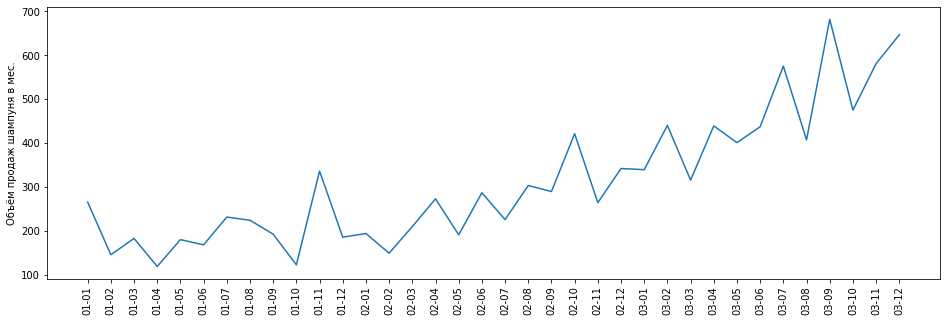

In [823]:
plt.figure(figsize=(16,5))
plt.plot(data['Sales'])
plt.xticks(rotation=90)
plt.ylabel('Объём продаж шампуня в мес.')
plt.show();

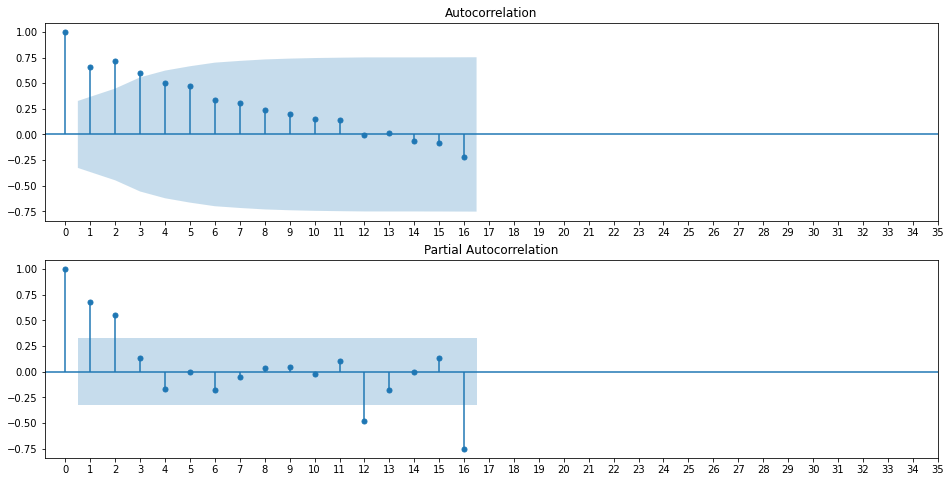

In [824]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,8)) 
sm.graphics.tsa.plot_acf(data['Sales'].values.squeeze(), ax=ax1)
ax1.set_xticks(np.arange(data.shape[0]))
sm.graphics.tsa.plot_pacf(data['Sales'].values.squeeze(), ax=ax2)
ax2.set_xticks(np.arange(data.shape[0]))
plt.show();

Этот ряд явно имеет тренд, но я бы сказала, что, скорее, нет ни сезонности, ни изменения дисперсии со временем.

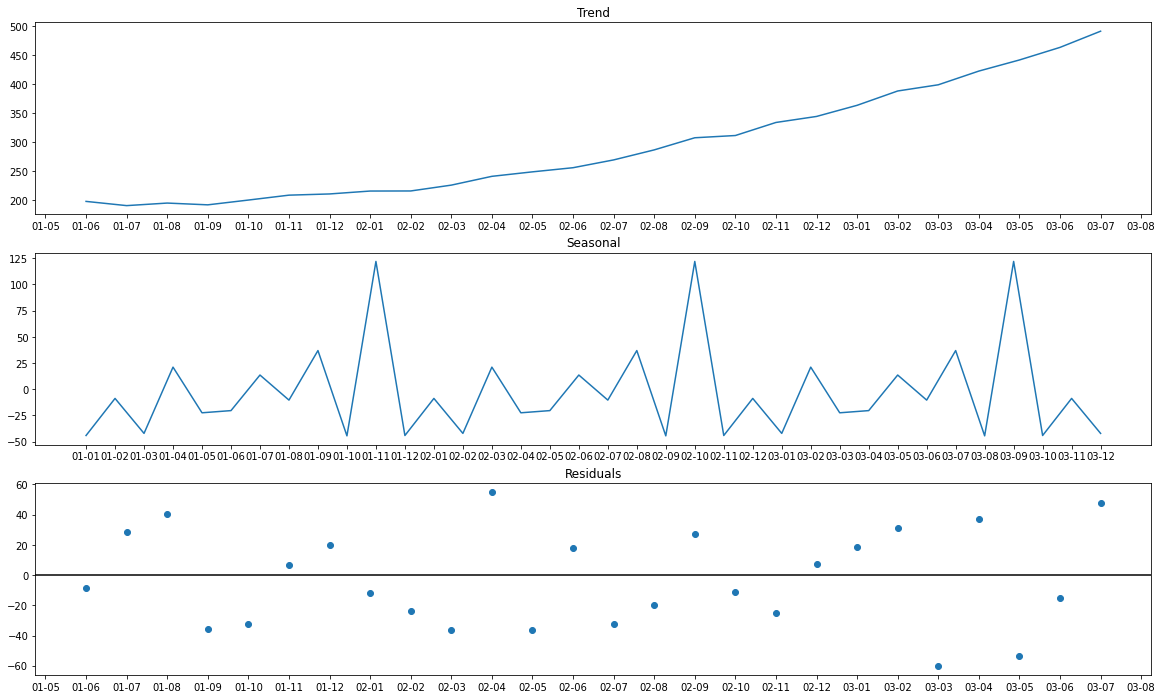

In [825]:
stl = sm.tsa.seasonal_decompose(data['Sales'], model='additive', period=11)
data['trend'] = stl.trend
data['seasonal'] = stl.seasonal
data['resid'] = stl.resid

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,12))
ax1.plot(data['trend'])
ax1.set_title('Trend')
ax2.plot(data['seasonal'])
ax2.set_title('Seasonal')
ax3.scatter(data.index, data['resid'])
ax3.set_title('Residuals')
plt.axhline(0, color='black')
plt.show();

Уберём из ряда тренд и проверим, станет ли он стационарным.

In [826]:
data['Sales_notr'] = data['Sales'].diff(1)

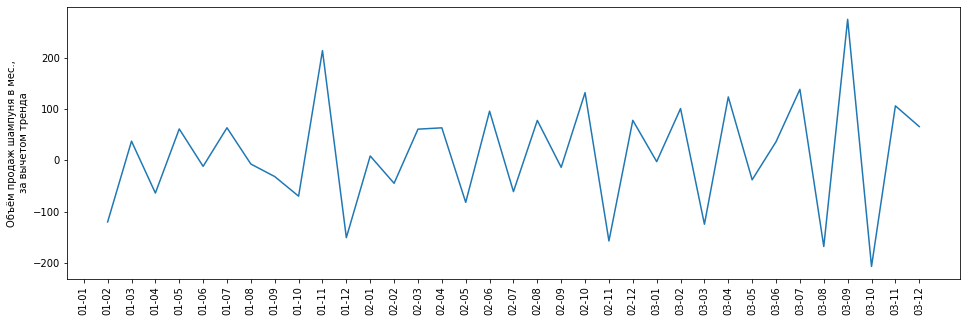

In [828]:
plt.figure(figsize=(16,5))
plt.plot(data['Sales_notr'])
plt.xticks(rotation=90)
plt.ylabel('Объём продаж шампуня в мес.,\nза вычетом тренда')
plt.show();

Проверим ряд на стационарность с помощью критерия Дики-Фуллера:

In [829]:
sm.tsa.stattools.adfuller(data[data['Sales_notr'].notnull()]['Sales_notr'])

(-7.249074055553854,
 1.7998574141687034e-10,
 1,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 275.32503579406307)

Второе число в результатах - это p-value для статистики критерия Дики-Фуллера. Гипотеза о нестационариности отвергнута с достаточной степенью уверенности (p << 0.001).

Посмотрим на графики для автокорреляций и частных автокорреляций:

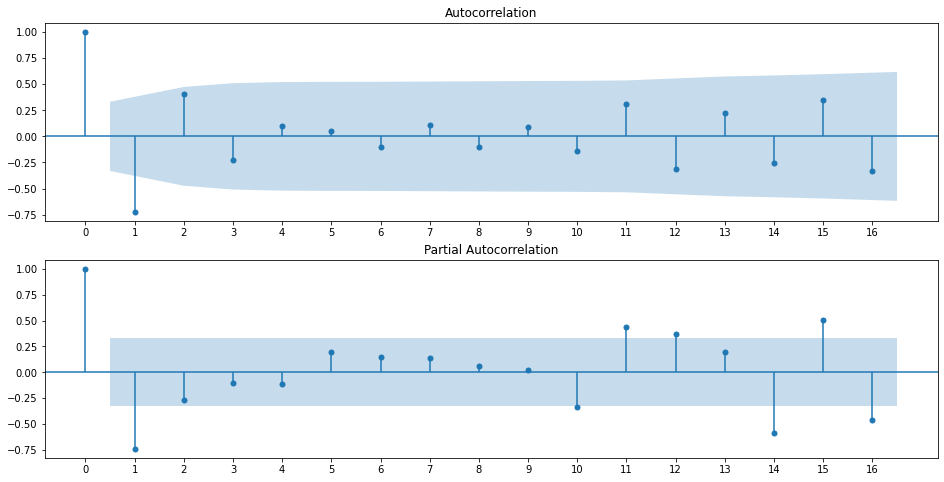

In [830]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,8)) 
sm.graphics.tsa.plot_acf(data[data['Sales_notr'].notnull()]['Sales_notr'].values.squeeze(), ax=ax1)
ax1.set_xticks(np.arange(17))
sm.graphics.tsa.plot_pacf(data[data['Sales_notr'].notnull()]['Sales_notr'].values.squeeze(), ax=ax2)
ax2.set_xticks(np.arange(17))
plt.show();

Поскольку и p, и q получаются ненулевыми, то выбрать их оптимальные значения исключительно по графикам довольно затруднительно, поэтому я воспользуюсь функцией auto_arima из пакета pmdarima для подбора всех параметров модели ARIMA. Я позволила модели выбрать d самостоятельно - оптимальным оказывается d=1, что и показал анализ выше.

In [832]:
arima_model = pmdarima.auto_arima(data['Sales'], 
                            start_p=0, start_q=0, max_p=4, max_q=4, d=None,
                            test='adf',  
                            m=1, seasonal=False, start_P=0, start_Q=0, D=0, 
                            trace=True, error_action='ignore', suppress_warnings=True, 
                            stepwise=True)
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.873, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=405.977, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=408.967, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429.229, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=403.573, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=404.633, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=404.226, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=402.407, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=401.463, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best 

Таким образом, оптимальной получается модель ARIMA(1,1,2) с константой. Критерий Ljung-Box не отвергает гипотезу о независимости остатков, но мы всё равно их проверим.

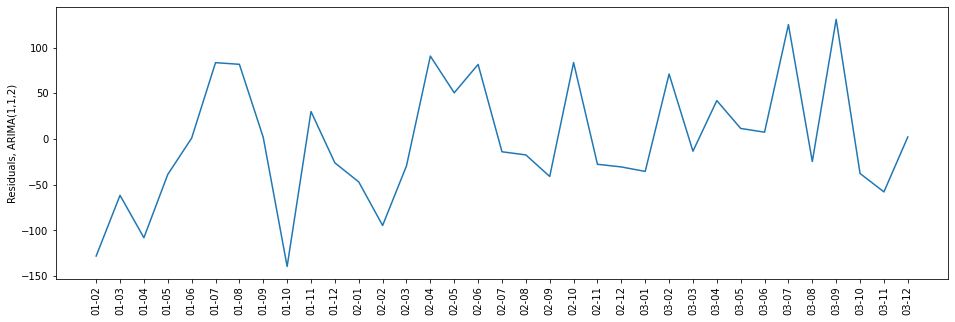

In [835]:
data['Resid_ARIMA'] = arima_model.resid()
plt.figure(figsize(16,5))
plt.plot(data[data['Sales_notr'].notnull()]['Resid_ARIMA'])
plt.ylabel('Residuals, ARIMA(1,1,2)')
plt.xticks(rotation=90)
plt.show();

Для начала оценим независимость остатков (отсутствие автокорреляции в них):

<Figure size 1152x360 with 0 Axes>

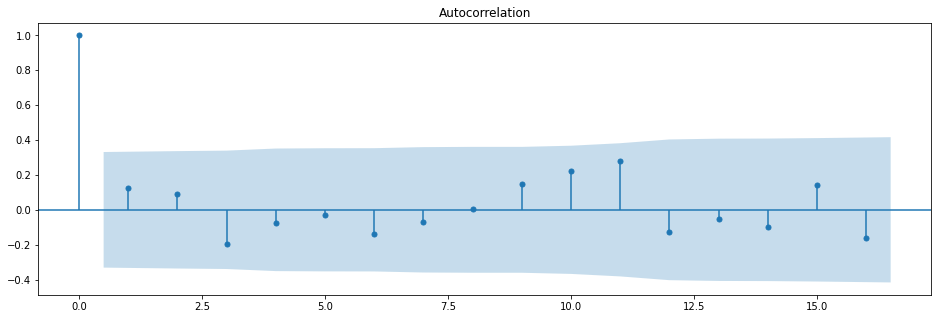

In [836]:
plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(data[data['Sales_notr'].notnull()]['Resid_ARIMA'].values.squeeze())
plt.show();

Автокорреляции нет.

Теперь оценим несмещённость (равенство среднего значения нулю).

In [838]:
data[data['Sales_notr'].notnull()]['Resid_ARIMA'].describe()

count     35.000000
mean      -2.292233
std       67.499098
min     -139.535196
25%      -38.331777
50%      -14.043558
75%       46.220287
max      130.862403
Name: Resid_ARIMA, dtype: float64

Поскольку наблюдения являются зависимыми, оптимально сделать это с помощью критерия знаков. Правда, он проверяет нулевую гипотезу о равенстве медианы, а не среднего значения нулю, но в нашем случае среднее значение ещё ближе к нулю, чем медиана.

In [839]:
from statsmodels.stats.descriptivestats import sign_test
sign_test(data[data['Sales_notr'].notnull()]['Resid_ARIMA'])

(-1.5, 0.735878800856881)

Нулевая гипотеза не отвергается (p=0.74), то есть можем считать, что остатки несмещённые.

Наконец, с помощью критерия Дики-Фулера проверим, являются ли остатки стационарным временным рядом.

In [840]:
sm.tsa.stattools.adfuller(data[data['Sales_notr'].notnull()]['Resid_ARIMA'])

(-5.27618296865725,
 6.133199668432578e-06,
 0,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 268.1761105749152)

Гипотеза о нестационарности уверенно отвергается, то есть остатки являются стационарными.

Соотношение фактических значений ряда с аппроксимированными с помощью модели:

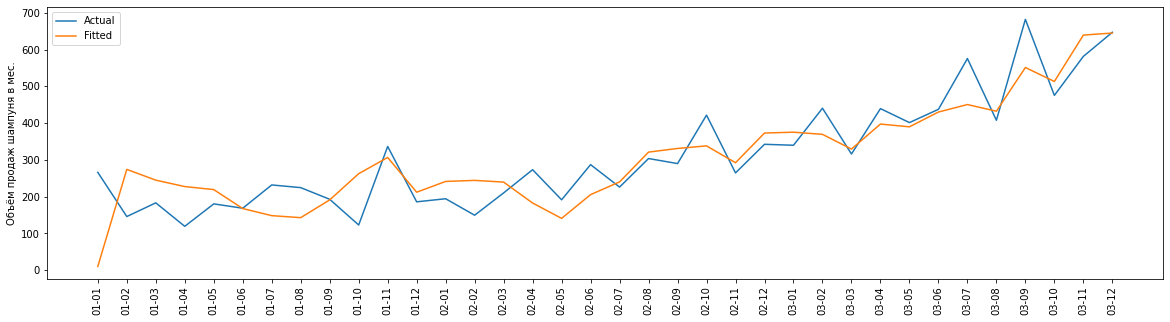

In [842]:
plt.figure(figsize(20,5))
plt.plot(data['Sales'], label='Actual')
plt.plot(arima_model.predict_in_sample(), label='Fitted')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Объём продаж шампуня в мес.')
plt.show();

Прогноз на следующие 3 месяца:

In [843]:
arima_model.predict(3)

array([605.40006434, 613.0044718 , 622.98788438])

На графике вместе с доверительным интервалом:

In [844]:
frcst, frcst_ci = arima_model.predict(3, return_conf_int=True)
data_frcst = pd.DataFrame({'Sales': frcst, 'Sales_lb': frcst_ci[:,0], 'Sales_ub': frcst_ci[:,1]}, index=['1904-01', '1904-02', '1904-03'])
data_frcst.index = pd.to_datetime(data_frcst.index)
data_frcst.index = data_frcst.index.strftime('%y-%m')
data_frcst

,Sales,Sales_lb,Sales_ub
04-01,605.400064,485.403010,725.397118
04-02,613.004472,488.129962,737.878982
04-03,622.987884,483.062703,762.913065


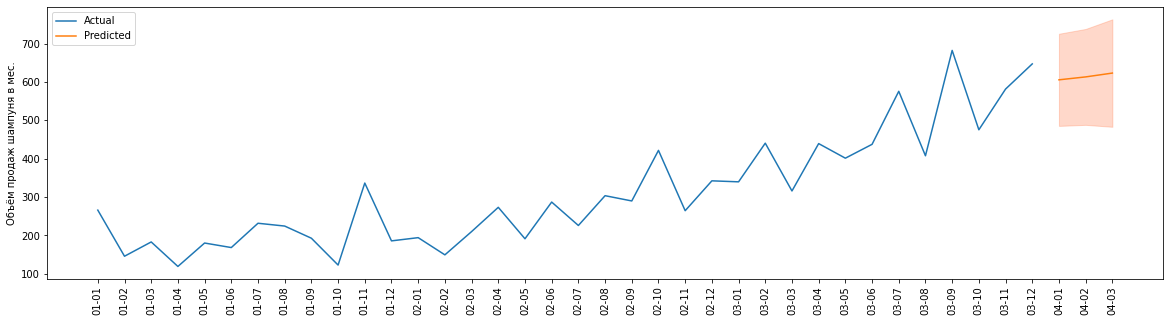

In [845]:
plt.figure(figsize(20,5))
plt.plot(data['Sales'], label='Actual')
plt.plot(data_frcst['Sales'], label='Predicted')
plt.fill_between(data_frcst.index,
                 data_frcst['Sales_lb'], 
                 data_frcst['Sales_ub'], 
                 color='coral', alpha=.3)
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Объём продаж шампуня в мес.')
plt.show();

### **Задание 3**

In [846]:
data = pd.read_csv("female-births.csv", sep=',', index_col=['Date'], parse_dates=['Date'], dayfirst=False) 
data

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


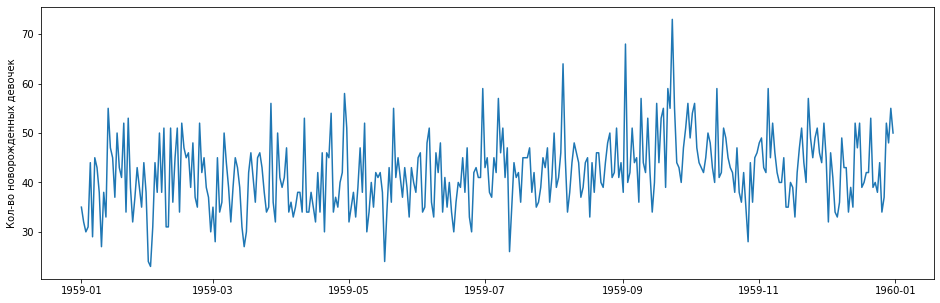

In [847]:
plt.figure(figsize=(16,5))
plt.plot(data['Births'])
plt.ylabel('Кол-во новорожденных девочек')
plt.show();

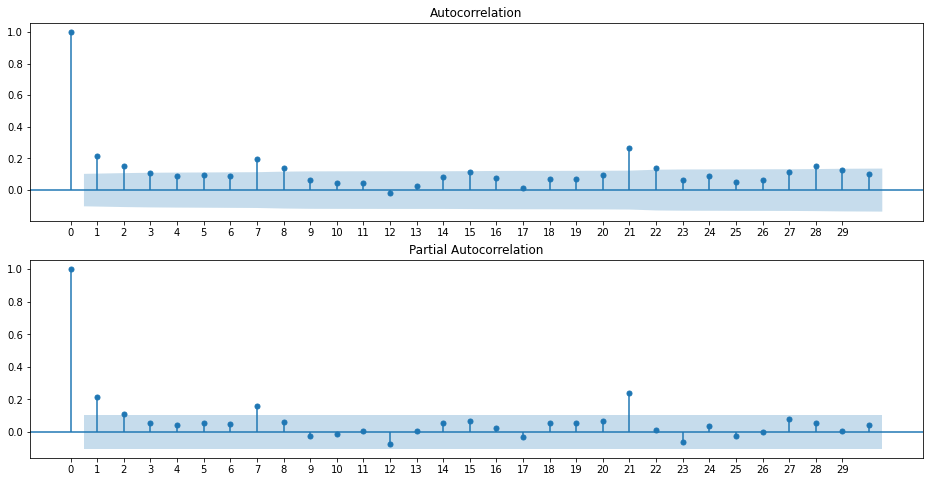

In [848]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,8)) 
sm.graphics.tsa.plot_acf(data['Births'].values.squeeze(), lags=30, ax=ax1)
ax1.set_xticks(np.arange(30))
sm.graphics.tsa.plot_pacf(data['Births'].values.squeeze(), lags=30, ax=ax2)
ax2.set_xticks(np.arange(30))
plt.show();

Этот ряд имеет слабый тренд и есть основания предполагать, что у него есть недельная сезонность.

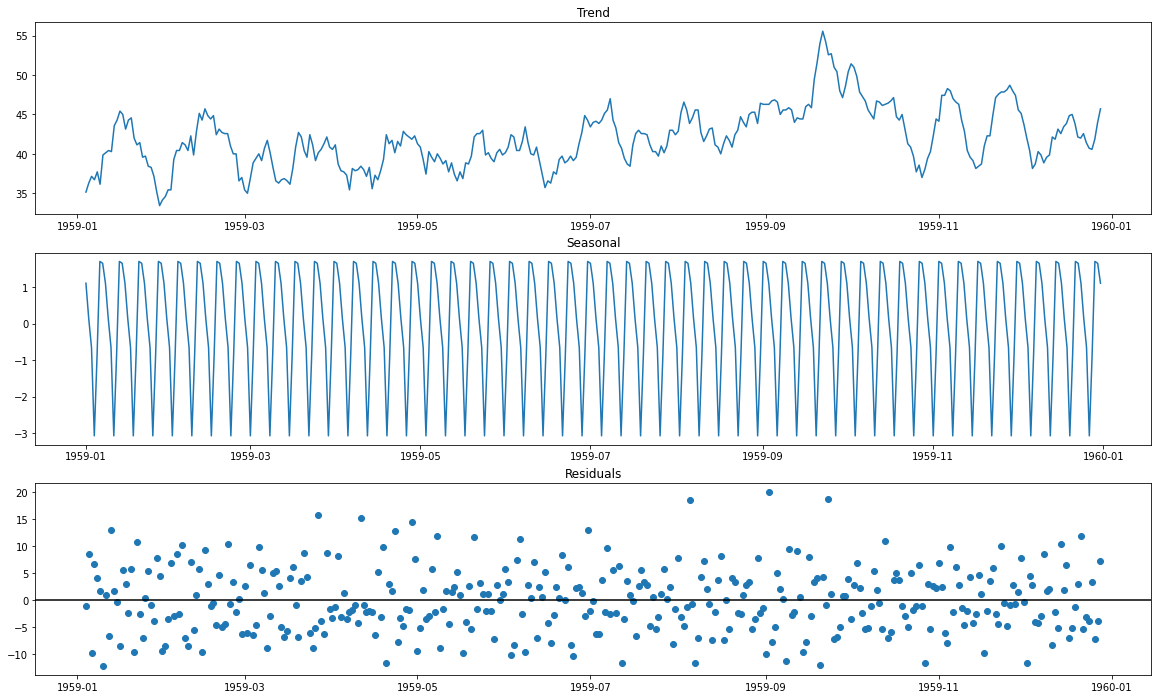

In [849]:
stl = sm.tsa.seasonal_decompose(data['Births'], model='additive')
data['trend'] = stl.trend
data['seasonal'] = stl.seasonal
data['resid'] = stl.resid

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,12))
ax1.plot(data['trend'])
ax1.set_title('Trend')
ax2.plot(data['seasonal'])
ax2.set_title('Seasonal')
ax3.scatter(data.index, data['resid'])
ax3.set_title('Residuals')
plt.axhline(0, color='black')
plt.show();

In [851]:
data['Births_notr'] = data['Births'].diff(1)

Проверим ряд на стационарность с помощью критерия Дики-Фуллера:

In [852]:
sm.tsa.stattools.adfuller(data[data['Births_notr'].notnull()]['Births_notr'])

(-12.625178633871343,
 1.5472400091969784e-23,
 6,
 357,
 {'1%': -3.44880082033912,
  '5%': -2.869670179576637,
  '10%': -2.5711012838861036},
 2355.0565353964653)

Гипотеза о нестационарности отвергается.

Уберём из ряда сезонную компоненту и проверим, останется ли он стационарным.

In [853]:
data['Births_noseas'] = data['Births_notr'].diff(7)

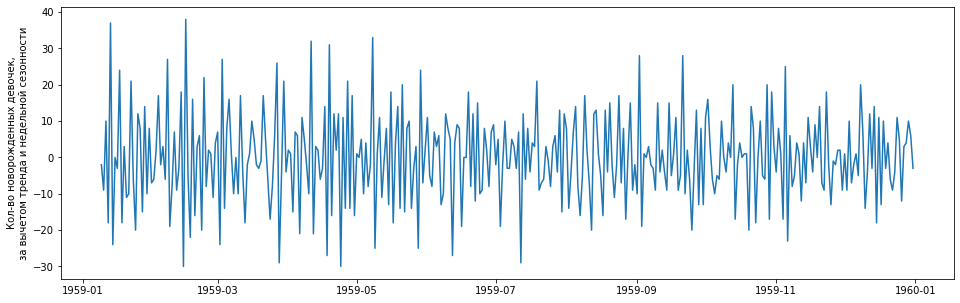

In [854]:
plt.figure(figsize=(16,5))
plt.plot(data['Births_noseas'])
plt.ylabel('Кол-во новорожденных девочек,\nза вычетом тренда и недельной сезонности')
plt.show();

In [855]:
sm.tsa.stattools.adfuller(data[data['Births_noseas'].notnull()]['Births_noseas'])

(-9.02411715196427,
 5.670757868327007e-15,
 17,
 339,
 {'1%': -3.4497880749874628,
  '5%': -2.870103829170425,
  '10%': -2.571332495975496},
 2369.0189034661116)

Ряд остался стационарным.

Посмотрим на графики для автокорреляций и частных автокорреляций для ряда за вычетом сезонности:

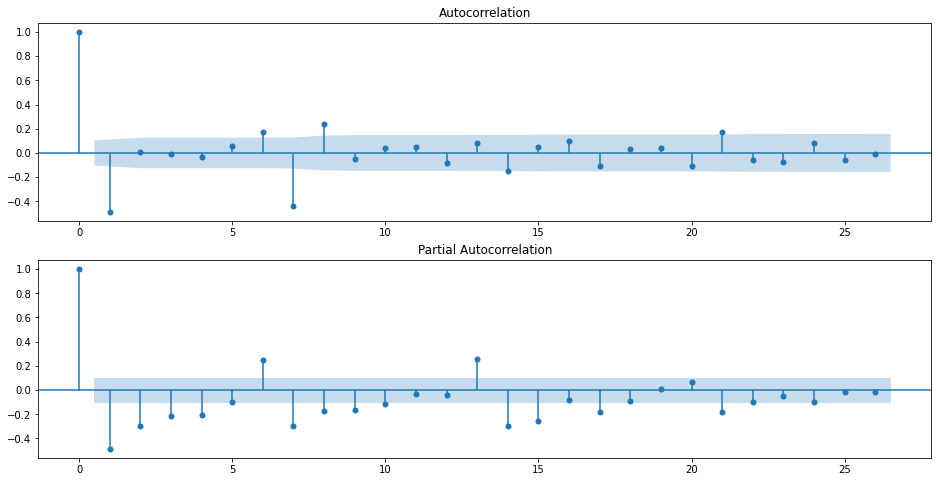

In [856]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,8)) 
sm.graphics.tsa.plot_acf(data[data['Births_noseas'].notnull()]['Births_noseas'].values.squeeze(), ax=ax1)
sm.graphics.tsa.plot_pacf(data[data['Births_noseas'].notnull()]['Births_noseas'].values.squeeze(), ax=ax2)
plt.show();

По этим графикам я бы предположила, что p=4-6, q=1, P=3, Q=2. Эту часть кода для поиска оптимального набора параметров для модели я взяла из ноутбука Леонида Иосипоя и Яна Пиле [здесь](http://iosipoi.com/teachingfiles/stat3/Notebooks_Topic5.zip).

In [606]:
ps = range(0, 7)
qs = range(0, 2)
Ps = range(0, 4)
Qs = range(0, 3)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

results = [] 
warnings.filterwarnings('ignore') 

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data['Births'], 
                                          order=(param[0], 1, param[1]), 
                                          seasonal_order=(param[2], 1, param[3], 7)).fit(disp=-1)
    
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

In [607]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
70,"(2, 1, 3, 1)",2421.269779
46,"(1, 1, 3, 1)",2421.378717
22,"(0, 1, 3, 1)",2422.894905
94,"(3, 1, 3, 1)",2422.907035
151,"(6, 0, 2, 1)",2423.972278


Я попробовала тесты ниже на каждой из этих 5 моделей - оптимальной, на мой взгляд, является модель SARIMA(3,1,1)(3,1,1)7. Посмотрим на её результаты.

In [857]:
sarima_model = sm.tsa.statespace.SARIMAX(data['Births'], 
                                          order=(3, 1, 1), 
                                          seasonal_order=(3, 1, 1, 7)).fit(disp=-1)
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Births   No. Observations:                  365
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 7)   Log Likelihood               -1202.454
Date:                           Sat, 07 Aug 2021   AIC                           2422.907
Time:                                   23:54:46   BIC                           2457.807
Sample:                               01-01-1959   HQIC                          2436.788
                                    - 12-31-1959                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1102      0.061      1.808      0.071      -0.009       0.230
ar.L2          0.0818      0.061      1.351

Посмотрим на остатки модели. Критерий Ljung-Box не отвергает гипотезу о независимости остатков.

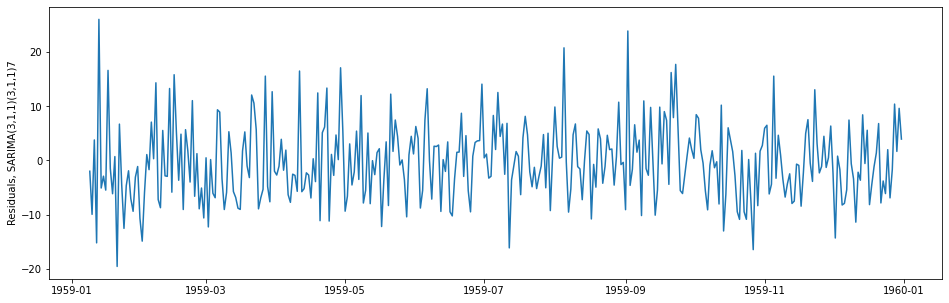

In [858]:
data['Resid_SARIMA'] = sarima_model.resid
plt.figure(figsize(16,5))
plt.plot(data[data['Births_noseas'].notnull()]['Resid_SARIMA'])
plt.ylabel('Residuals, SARIMA(3,1,1)(3,1,1)7')
plt.show();

Для начала оценим независимость остатков (отсутствие автокорреляции в них):

<Figure size 1152x360 with 0 Axes>

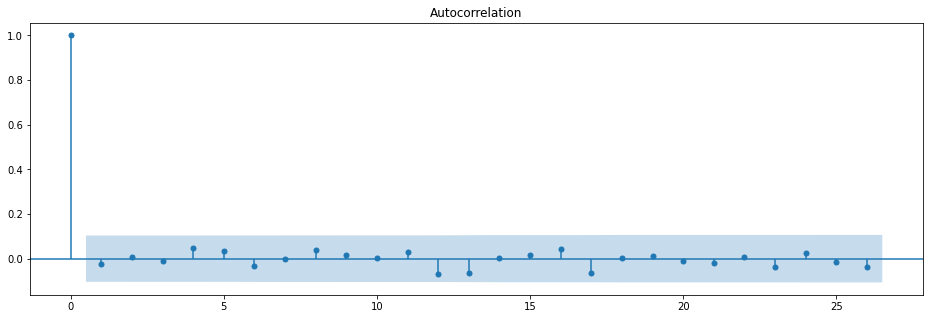

In [859]:
plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(data[data['Births_noseas'].notnull()]['Resid_SARIMA'].values.squeeze())
plt.show();

Автокорреляции нет.

Теперь оценим несмещённость (равенство среднего значения нулю).

In [860]:
data[data['Births_noseas'].notnull()]['Resid_SARIMA'].describe()

count    357.000000
mean      -0.312493
std        7.120513
min      -19.598320
25%       -5.451443
50%       -0.895594
75%        4.429053
max       26.071967
Name: Resid_SARIMA, dtype: float64

In [861]:
sign_test(data[data['Births_noseas'].notnull()]['Resid_SARIMA'])

(-16.5, 0.09019705395655157)

Нулевая гипотеза о равенстве медианы нулю не отвергается (p=0.09), то есть можем считать, что остатки несмещённые. 

Наконец, с помощью критерия Дики-Фулера проверим, являются ли остатки стационарным временным рядом.

In [862]:
sm.tsa.stattools.adfuller(data[data['Births_noseas'].notnull()]['Resid_SARIMA'])

(-19.271705520481163,
 0.0,
 0,
 356,
 {'1%': -3.448853029339765,
  '5%': -2.869693115704379,
  '10%': -2.571113512498422},
 2273.043302560847)

Гипотеза о нестационарности уверенно отвергается, то есть остатки являются стационарными.

Соотношение фактических значений ряда с аппроксимированными с помощью модели (округлю кол-во до ближайшего большего целого числа):

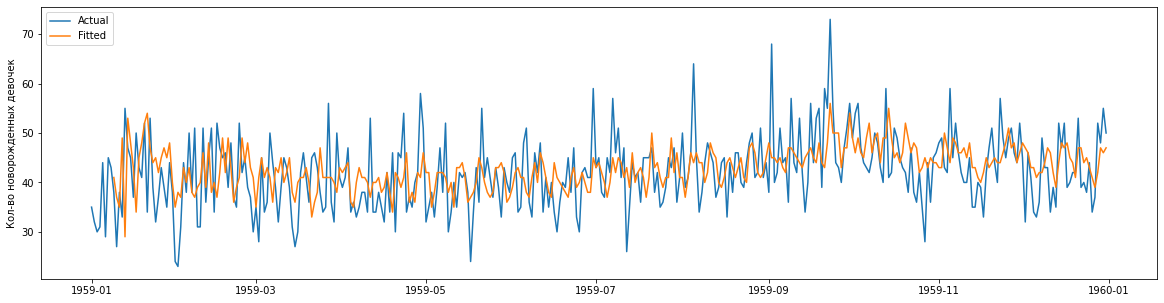

In [863]:
data['Fitted_SARIMA'] = ceil(sarima_model.fittedvalues)
plt.figure(figsize(20,5))
plt.plot(data['Births'], label='Actual')
plt.plot(data[data['Births_noseas'].notnull()]['Fitted_SARIMA'], label='Fitted')
plt.legend(loc='upper left')
plt.ylabel('Кол-во новорожденных девочек')
plt.show();

Прогноз на следующий месяц:

In [864]:
data_frcst = pd.DataFrame(ceil(sarima_model.predict(start=365, end=395)))
data_frcst

,predicted_mean
1960-01-01,45.0
1960-01-02,43.0
1960-01-03,41.0
1960-01-04,47.0
1960-01-05,48.0
1960-01-06,50.0
1960-01-07,46.0
1960-01-08,44.0
1960-01-09,44.0
1960-01-10,42.0


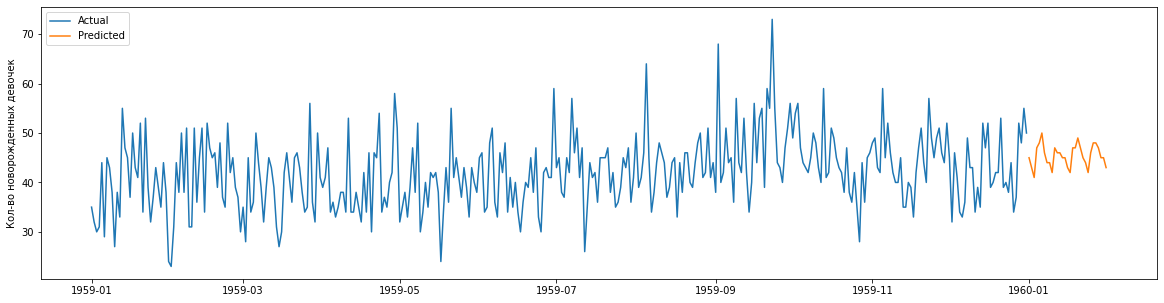

In [865]:
plt.figure(figsize(20,5))
plt.plot(data['Births'], label='Actual')
plt.plot(data_frcst, label='Predicted')
plt.legend(loc='upper left')
plt.ylabel('Кол-во новорожденных девочек')
plt.show();

### **Задание 4**

In [866]:
data = pd.read_csv("anti-diabetic-drugs.csv", sep=',', index_col=['date'], parse_dates=['date'], dayfirst=False) 
data

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


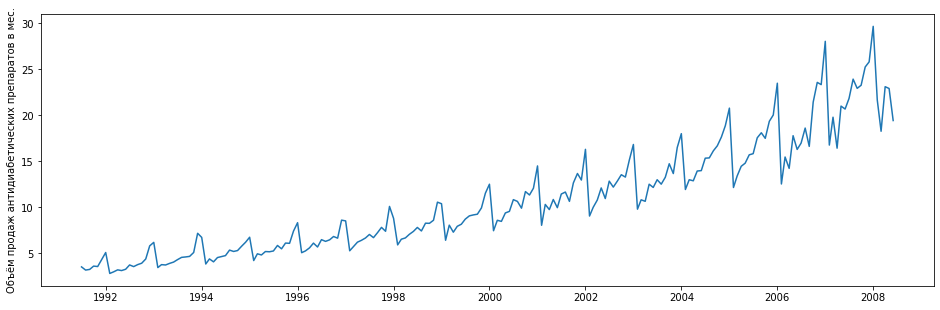

In [867]:
plt.figure(figsize=(16,5))
plt.plot(data['value'])
plt.ylabel('Объём продаж антидиабетических препаратов в мес.')
plt.show();

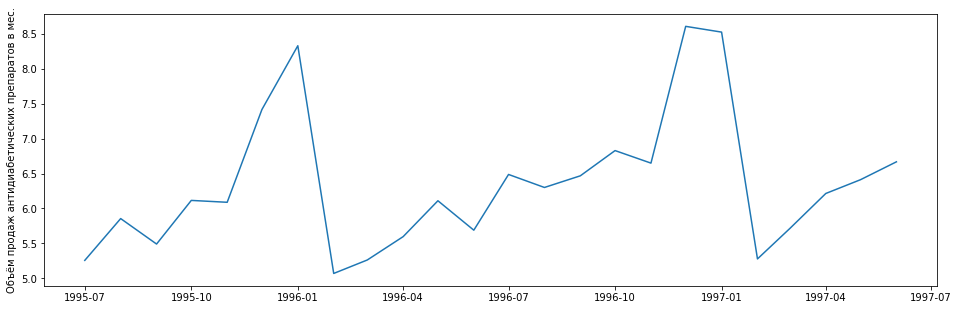

In [868]:
plt.figure(figsize=(16,5))
plt.plot(data['value'][48:72])
plt.ylabel('Объём продаж антидиабетических препаратов в мес.')
plt.show();

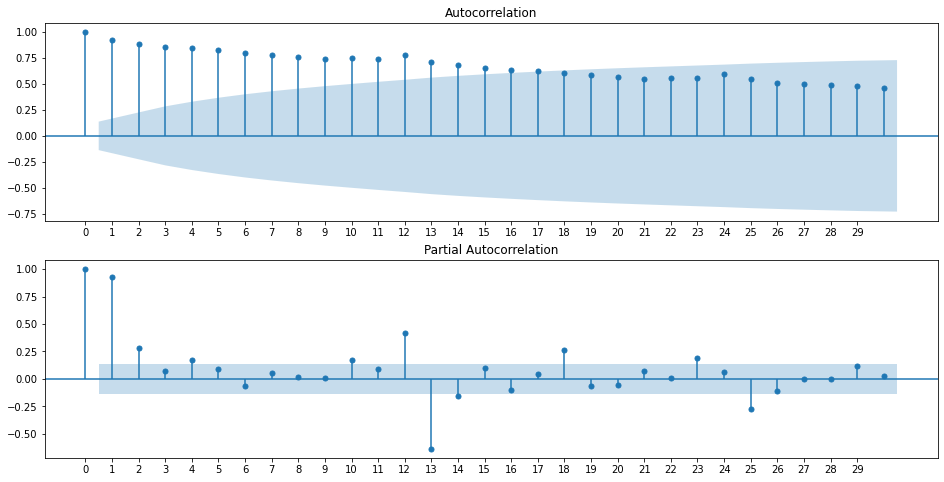

In [869]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,8)) 
sm.graphics.tsa.plot_acf(data['value'].values.squeeze(), lags=30, ax=ax1)
ax1.set_xticks(np.arange(30))
sm.graphics.tsa.plot_pacf(data['value'].values.squeeze(), lags=30, ax=ax2)
ax2.set_xticks(np.arange(30))
plt.show();

Этот ряд имеет выраженный тренд и есть основания предполагать, что у него есть годовая сезонность (пик продаж - в январе) и увеличивающаяся со временем дисперсия.

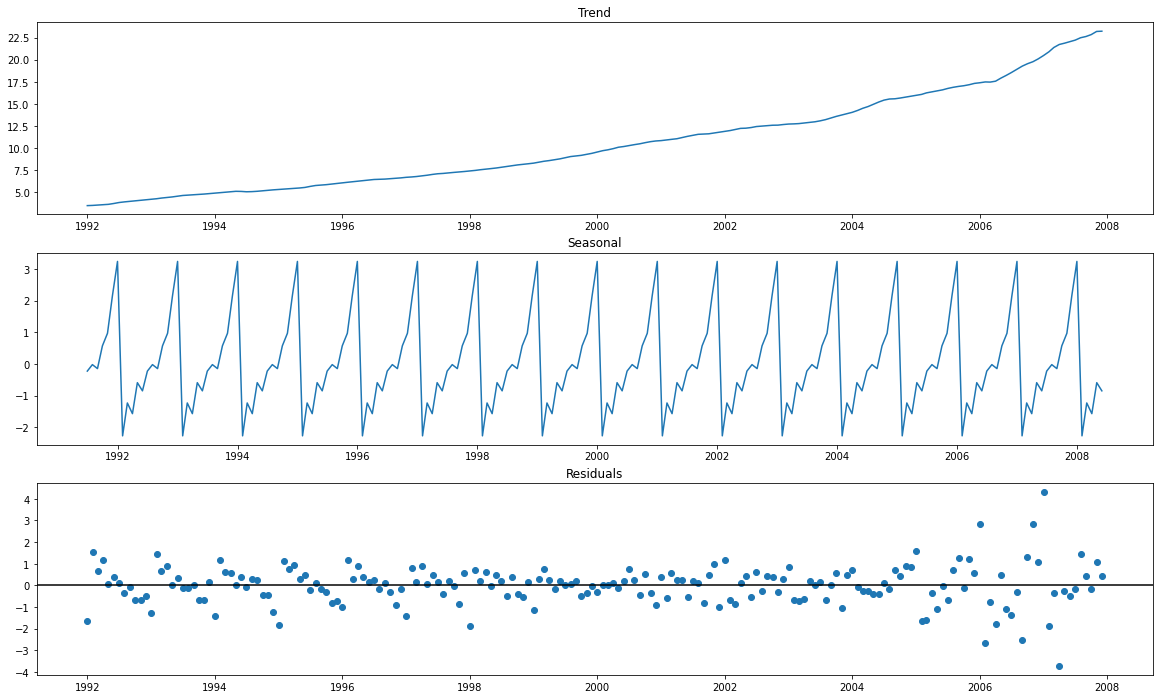

In [870]:
stl = sm.tsa.seasonal_decompose(data['value'], model='additive')
data['trend'] = stl.trend
data['seasonal'] = stl.seasonal
data['resid'] = stl.resid

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,12))
ax1.plot(data['trend'])
ax1.set_title('Trend')
ax2.plot(data['seasonal'])
ax2.set_title('Seasonal')
ax3.scatter(data.index, data['resid'])
ax3.set_title('Residuals')
plt.axhline(0, color='black')
plt.show();

По графику остатков видно, что дисперсия действительно не является постоянной во времени - применим преобразование Бокса-Кокса, чтобы это скорректировать.

In [871]:
data['value_bc'], bc_lambda = stats.boxcox(data['value'])

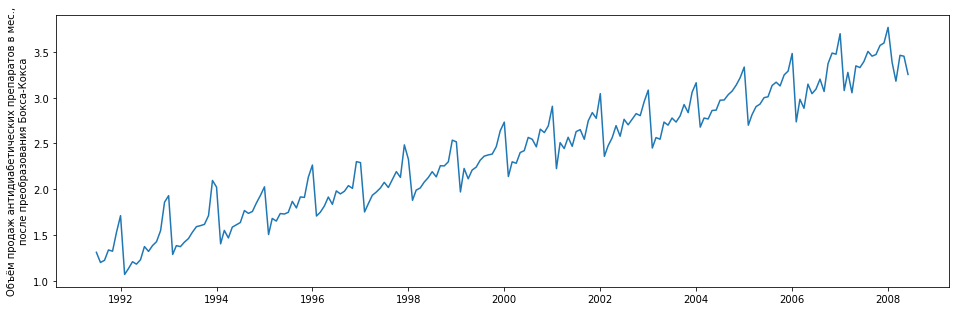

In [872]:
plt.figure(figsize=(16,5))
plt.plot(data['value_bc'])
plt.ylabel('Объём продаж антидиабетических препаратов в мес.,\nпосле преобразования Бокса-Кокса')
plt.show();

Теперь избавимся от сезонности, а затем от тренда:

In [873]:
data['value_noseas'] = data['value_bc'].diff(12)
data['value_notr'] = data['value_noseas'].diff(1)

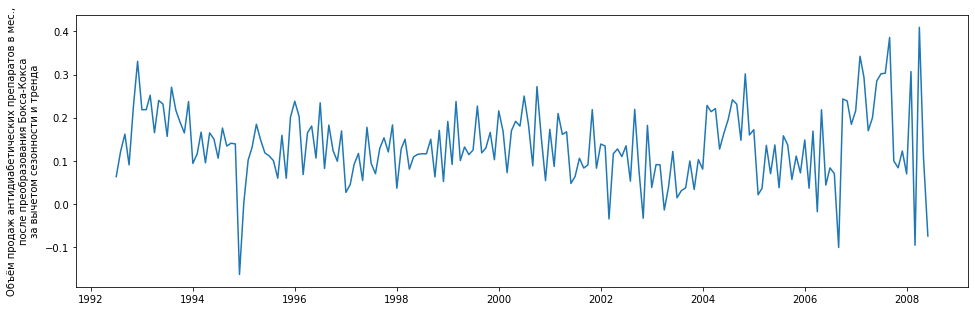

In [874]:
plt.figure(figsize=(16,5))
plt.plot(data['value_noseas'])
plt.ylabel('Объём продаж антидиабетических препаратов в мес.,\nпосле преобразования Бокса-Кокса\nза вычетом сезонности и тренда')
plt.show();

In [875]:
sm.tsa.stattools.adfuller(data[data['value_notr'].notnull()]['value_notr'])

(-4.805888237975746,
 5.299278344680782e-05,
 13,
 177,
 {'1%': -3.467845319799907,
  '5%': -2.878011745497439,
  '10%': -2.575551186759871},
 -371.4057391494332)

Гипотеза о нестационарности отвергается.

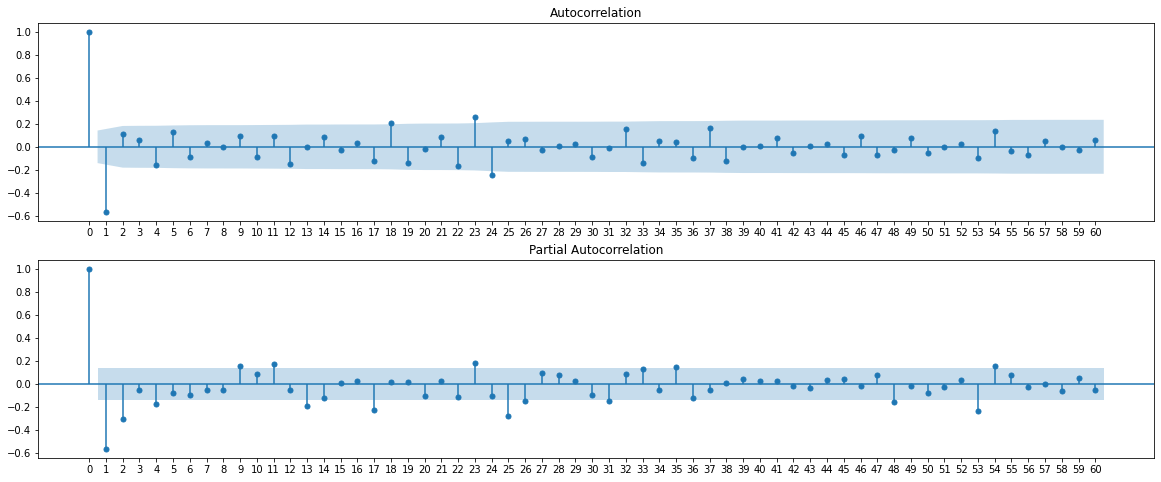

In [876]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,8)) 
sm.graphics.tsa.plot_acf(data[data['value_notr'].notnull()]['value_notr'].values.squeeze(), lags=60, ax=ax1)
ax1.set_xticks(np.arange(61))
sm.graphics.tsa.plot_pacf(data[data['value_notr'].notnull()]['value_notr'].values.squeeze(), lags=60, ax=ax2)
ax2.set_xticks(np.arange(61))
plt.show();

По этим графикам я бы предположила, что p=2-4, q=1, P=4, Q=2. Эту часть кода для поиска оптимального набора параметров для модели я взяла из ноутбука Леонида Иосипоя и Яна Пиле [здесь](http://iosipoi.com/teachingfiles/stat3/Notebooks_Topic5.zip).

In [800]:
ps = range(5)
qs = range(2)
Ps = range(5)
Qs = range(3)

from itertools import product
parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

results = [] 
warnings.filterwarnings('ignore') 

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data['value_bc'], 
                                          order=(param[0], 1, param[1]), 
                                          seasonal_order=(param[2], 1, param[3], 12)).fit(disp=-1)
    
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

In [801]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']
result_table.sort_values(by = 'AIC', ascending=True).head(10)

,Parameters,AIC
112,"(3, 1, 2, 1)",-466.049907
142,"(4, 1, 2, 1)",-465.641351
148,"(4, 1, 4, 1)",-463.819852
143,"(4, 1, 2, 2)",-463.774538
119,"(3, 1, 4, 2)",-463.649473


Я попробовала тесты ниже на каждой из этих 5 моделей - оптимальной, на мой взгляд, является модель SARIMA(4,1,1)(2,1,1)12. Посмотрим на её результаты.

In [893]:
sarima_model2 = sm.tsa.statespace.SARIMAX(data['value_bc'], 
                                          order=(4, 1, 1), 
                                          seasonal_order=(2, 1, 1, 12)).fit(disp=-1)
print(sarima_model2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           value_bc   No. Observations:                  204
Model:             SARIMAX(4, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 241.821
Date:                            Sun, 08 Aug 2021   AIC                           -465.641
Time:                                    00:01:06   BIC                           -436.371
Sample:                                07-01-1991   HQIC                          -453.785
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0305      0.095     -0.320      0.749      -0.217       0.156
ar.L2          0.2168      0.115   

Посмотрим на остатки модели. Критерий Ljung-Box не отвергает гипотезу о независимости остатков.

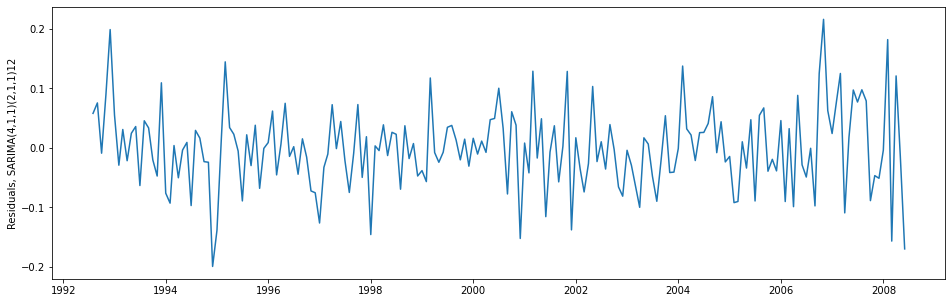

In [894]:
data['Resid_SARIMA'] = sarima_model2.resid
plt.figure(figsize(16,5))
plt.plot(data[data['value_notr'].notnull()]['Resid_SARIMA'])
plt.ylabel('Residuals, SARIMA(4,1,1)(2,1,1)12')
plt.show();

Для начала оценим независимость остатков (отсутствие автокорреляции в них):

<Figure size 1152x360 with 0 Axes>

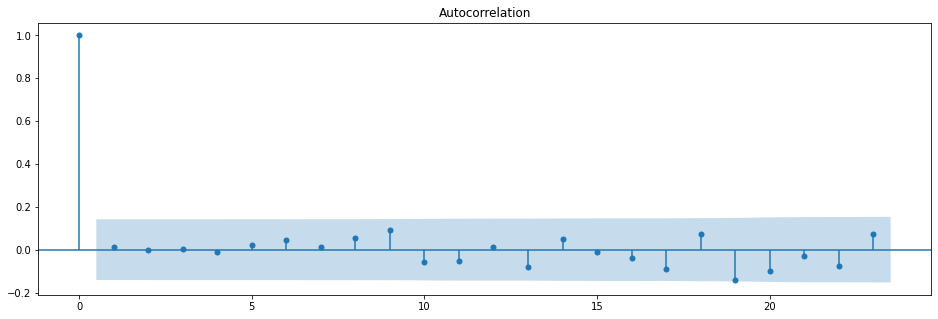

In [895]:
plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(data[data['value_notr'].notnull()]['Resid_SARIMA'].values.squeeze())
plt.show();

Автокорреляции нет.

Теперь оценим несмещённость (равенство среднего значения нулю).

In [896]:
data[data['value_notr'].notnull()]['Resid_SARIMA'].describe()

count    191.000000
mean      -0.001014
std        0.068078
min       -0.199033
25%       -0.041001
50%       -0.002634
75%        0.037457
max        0.215829
Name: Resid_SARIMA, dtype: float64

In [897]:
sign_test(data[data['value_notr'].notnull()]['Resid_SARIMA'])

(-4.5, 0.562798485791095)

Нулевая гипотеза о равенстве медианы нулю не отвергается (p=0.56), то есть можем считать, что остатки несмещённые. 

Наконец, с помощью критерия Дики-Фулера проверим, являются ли остатки стационарным временным рядом.

In [898]:
sm.tsa.stattools.adfuller(data[data['Resid_SARIMA'].notnull()]['Resid_SARIMA'])

(-22.164279915639767,
 0.0,
 0,
 203,
 {'1%': -3.462980134086401,
  '5%': -2.875885461947131,
  '10%': -2.5744164898444515},
 -472.891682578869)

Гипотеза о нестационарности уверенно отвергается, то есть остатки являются стационарными.

Соотношение фактических значений ряда с аппроксимированными с помощью модели:

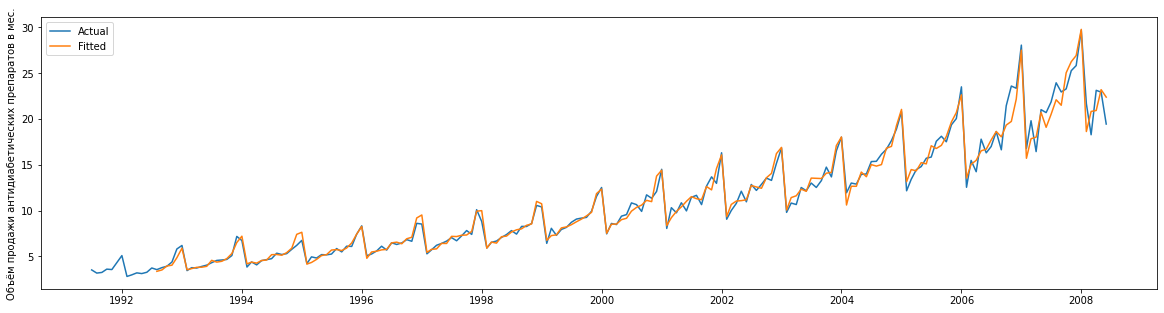

In [901]:
data['Fitted_SARIMA'] = inv_boxcox(sarima_model2.fittedvalues, bc_lambda)
plt.figure(figsize(20,5))
plt.plot(data['value'], label='Actual')
plt.plot(data[data['value_notr'].notnull()]['Fitted_SARIMA'], label='Fitted')
plt.legend(loc='upper left')
plt.ylabel('Объём продажи антидиабетических препаратов в мес.')
plt.show();

Прогноз на следующий год:

In [902]:
data_frcst = pd.DataFrame(inv_boxcox(sarima_model2.predict(start=data.shape[0], end=data.shape[0]+12), bc_lambda))
data_frcst

,predicted_mean
2008-07-01,25.824848
2008-08-01,23.889848
2008-09-01,24.873024
2008-10-01,26.666994
2008-11-01,26.337368
2008-12-01,29.408715
2009-01-01,32.956494
2009-02-01,20.595977
2009-03-01,21.625241
2009-04-01,23.349678


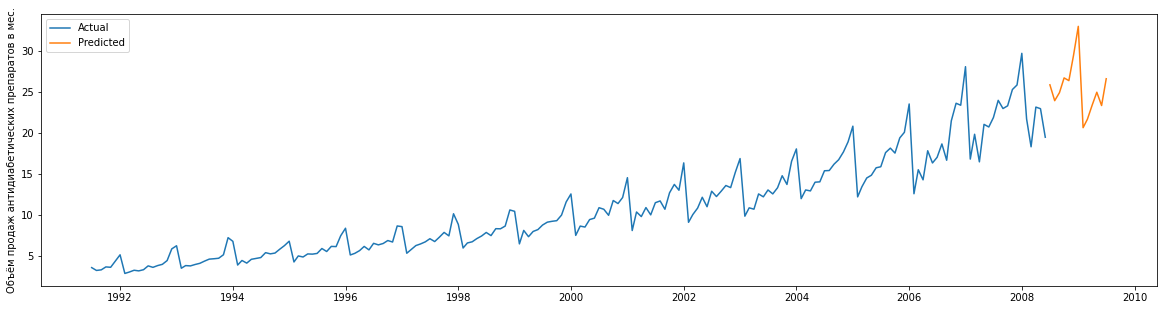

In [903]:
plt.figure(figsize(20,5))
plt.plot(data['value'], label='Actual')
plt.plot(data_frcst, label='Predicted')
plt.legend(loc='upper left')
plt.ylabel('Объём продаж антидиабетических препаратов в мес.')
plt.show();